<h1>Chaos - Computational Lab<br/> Numerical Simulation of the Duffing-Harmonic Oscillator</h1>

<h3>Author: V Vijendran</h3>

In [1]:
import math
import itertools
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from sympy import *
from numba import jit
from sympy.interactive import printing
from scipy.integrate import odeint
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D

printing.init_printing(use_latex=True)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## 1. Deriving the Inverted Pendulum's Equation of Motion
-----

We will consider the case of an inverted pendulum that is formed by attaching a mass to an initially straight rod that can be bent elastically with the assumption that the straight rod bends only left or right. We choose a polar coordinate system defined by $(\hat{r}, \hat{\phi})$ such that the $\hat{r}$ is always pointing in the direction of the pendulum's length and $\hat{\phi}$ is instead orthogonal to it.

By balancing the sum of the forces acting on the mass $m$,we know that in the $\hat{\phi}$ direction the following
equation is satisfied: 

\begin{align*}
ml \ddot{\phi} &= F_g \sin \phi - \alpha \phi
\end{align*}

where $l$ is the length of the pendulum, $F_{\mathrm{g}}=m g$ is the gravitational force dependent on the
acceleration $g=9.81 \mathrm{~ms}^{-2}$, and $\alpha$ is a dimensionless constant that determines the elasticity of the rod. In the case of the inverted pendulum, $\alpha \phi$ acts as the restoring force in place of gravity.

We can account for a viscous damping force $F_{\mathrm{v}}=-m \gamma l \dot{\phi}$ from air resistance that is directly proportional to the (angular) velocity of the mass $\dot{\phi}$, and also include an unspecified driving force $F_{dr}$ to obtain the full expression of a damped driven inverted pendulum:

\begin{align*}
ml \ddot{\phi} &= F_g \sin \phi - \alpha \phi + F_{\mathrm{v}} + F_{dr}\\
ml \ddot{\phi} &= mg \sin \phi - \alpha \phi - m \gamma l \dot{\phi} + F_{dr}
\end{align*}

We can further simplify the expression as

\begin{align*}
ml \ddot{\phi} + m \gamma l \dot{\phi} + \alpha \phi - mg \sin \phi &= F_{dr}\\
\ddot{\phi} + \gamma \dot{\phi} + \dfrac{\alpha}{ml}  \phi - \omega_0^2 \sin \phi &= \dfrac{F_{dr}}{ml}\\
\end{align*}

where $\omega_{0}=\sqrt{\dfrac{g}{l}}$.

## 2. Small Angle Approximation: $\sin(\phi) \approx \phi$
-----

Having derived the inverted pendulum's equation of motion, we then make the small angle approximation $\sin(\phi) \approx \phi$ and set the system's sinusoidal driving force of frequency $\omega_{\mathrm{dr}}$ with $F_{\mathrm{dr}}=A \sin \left(\omega_{\mathrm{dr}} t\right)$. The resulting expression of the inverted pendulum's motion is

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} + \bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}



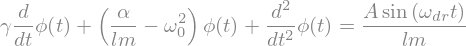

In [2]:
t, gamma, alpha, m, l, omega0, A, omegadr = sp.symbols('t, gamma, alpha, m, l, omega_0, A, omega_dr')
phi = sp.Function('phi')(t)
RHS = phi.diff(t,t)+gamma*phi.diff(t) + phi*(alpha/(m*l)-omega0**2)
LHS = A*sp.sin(omegadr*t)/(m*l)
eqn_motion = Eq(RHS, LHS)
eqn_motion

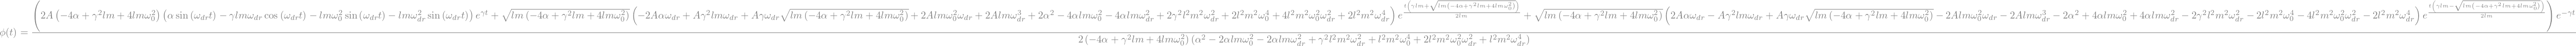

In [3]:
sol_eqn = dsolve(eqn_motion, phi, ics={phi.subs(t,0):0,phi.diff(t).subs(t,0):1})
simplify(sol_eqn)

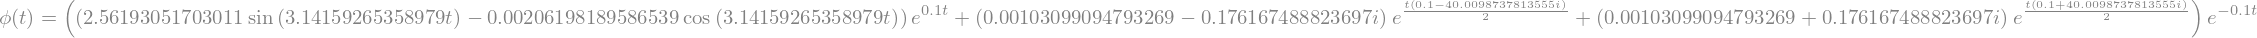

In [4]:
# If you are changing the variable value, restart the kernel and run from beginning
# Rerunning these following cells after variable change might throw an error
sol_eqn = sol_eqn.subs(omega0, sqrt(9.98/l))
sol_eqn = sol_eqn.subs(m,0.1)
sol_eqn = sol_eqn.subs(alpha, 5)
sol_eqn = sol_eqn.subs(gamma, 0.1)
sol_eqn = sol_eqn.subs(l, 0.1)
sol_eqn = sol_eqn.subs(A, 10)
sol_eqn = sol_eqn.subs(omegadr, np.pi)
simplify(sol_eqn)

In [5]:
eqn_t = lambdify(t, sol_eqn.rhs, modules=['numpy'])

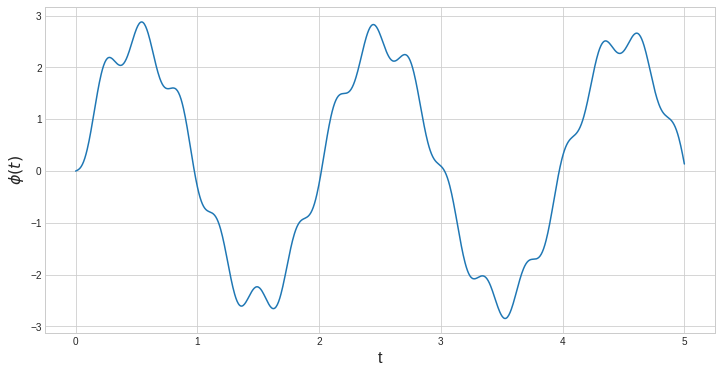

In [6]:
x = np.linspace(0,5, 1000)
y = [eqn_t(i).real for i in x]
plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.xlabel('t', fontsize=16)
plt.ylabel(r'$\phi(t)$', fontsize=16);

## 3. The Duffing Equation
-----

Since we know that the small angle approximation $\sin(\phi) \approx \phi$ fails to express the non-linearity of the inverted pendulum (when it flops around), we make use of the higher terms in the Taylor expansion $\sin \phi \approx \phi-\phi^{3} / 6$ resulting in the following equation

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} + \dfrac{\alpha}{ml}  \phi - \omega_0^2 \bigg(\phi - \dfrac{\phi^3}{6} \bigg) &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}

which can be further simplified into

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} + \bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi + \omega_0^2 \dfrac{\phi^3}{6}  &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}

## 4. Potential Energy of the System
-----

Without the non-conservative terms (damping and driving), the Duffing equation can be integrated to derive an expression for the potential energy of the system as a function of $\phi$:

\begin{align}
V(\phi) &= \dfrac{1}{2}\bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi^2 + \dfrac{1}{24}\omega_0^2 \phi^4
\end{align}

In [7]:
@jit(nopython=True)
def potential(phi, alpha, m=0.1, l=0.1):
    g = 9.98
    return 0.5*(alpha/(m*l)-(g/l))*(phi**2) + (1/24)*(g/l)*(phi**4)

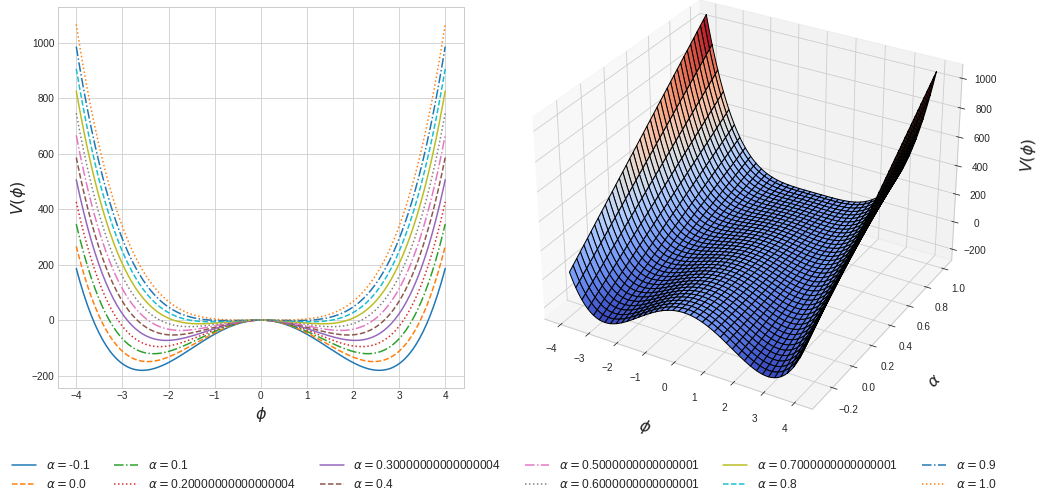

In [8]:
alphas = np.arange(-0.1, 1.05, 0.1)
phi = np.linspace(-4, 4, 200)

fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)

style=itertools.cycle(["-","--","-.",":"])

for alpha in alphas:
    V = potential(phi, alpha)
    ax1.plot(phi, V, linestyle=next(style), label = r'$\alpha = $' + f"{alpha}")
    
ax1.set_xlabel(r'$\phi$', fontsize=16)
ax1.set_ylabel(r'$V(\phi)$', fontsize=16)
ax1.legend(loc=8, ncol=6, bbox_to_anchor=[1.1,-.3,0,0], fontsize=12);

ax2 = fig.add_subplot(122, projection='3d')
phi = np.linspace(-4, 4, 200)
alpha = np.linspace(-0.3, 1, 200)
X, Y = np.meshgrid(phi,alpha)
Z = potential(X,Y)
ax2.plot_surface(X, Y, Z, rstride=5, cstride=5,cmap='coolwarm', edgecolor='black')
ax2.set_xlabel(r'$\phi$',fontsize=16)
ax2.set_ylabel(r'$\alpha$',fontsize=16)
ax2.set_zlabel(r'$V(\phi)$',fontsize=16)
# Set spacing b/w the labels and the plot.
ax2.xaxis.labelpad=15
ax2.yaxis.labelpad=15
ax2.zaxis.labelpad=15
ax2.dist=8;

## 5. Numerically Solving the Equation of Motion
-----

Our duffing equation is a second-order ODE of the form

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} + \bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi + \omega_0^2 \dfrac{\phi^3}{6}  &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}

which we would to numerically solve for the initial conditions $\phi(0) = 0$ and $\dot{\phi}(0) = 0$. We can turn the above second-order ODE into two first-order equations by defining a new independent variable $\theta$ as follows

\begin{align*}
\theta = \dot{\phi} \to \dot{\theta} + \gamma \theta + \bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi + \omega_0^2 \dfrac{\phi^3}{6}  &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}

and solve them for initial conditions $\phi(0) = 0$ and $\theta(0) = 0$.

We perform numerical integration of the above pair of first-order differential equations using the `odeint` method from the `scipy.integrate` package. We solve the duffing equation for $5000$ values of $t$ ranging from $0.0$ to $5.0$ with $A = 10$, $m = l = \gamma = 0.1$, $\alpha = 5$ and $\omega_{\mathrm{dr}} = \pi$. We also let $g \approx 10$.

To allow scipy to perform numerical calculations faster, we have made use the JIT (Just-In-Time) functionality from the `Numba` library. The JIT functionality is invoked by using the magic command `@jit` before the desired function. The argument `nopython=True` is used to indicate that in case of unexpected errors, fallback to Python is not allowed, i.e. it would throw an error instead of performing the much slower Python computation.

In [9]:
@jit(nopython=True)
def dy_dt(phi0,t, A, m, l, alpha, beta, gamma, omega_dr):
    g = 10
    omega_0 = np.sqrt(g/l)
    phi, theta = phi0 # phi0 is the vector [phi, theta]; contains the initial conditions of the system
    dtheta = A*np.sin(omega_dr*t)/(m*l) - gamma*theta - phi*(alpha/(m*l)-omega_0**2) - beta*(omega_0**2)*((phi**3)/6)
    dydt = [theta, dtheta]
    return dydt

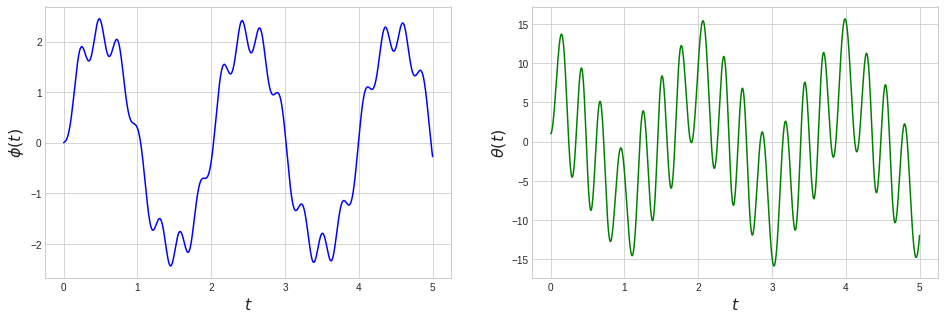

In [13]:
phi0 = [0, 1]
t = np.linspace(0, 5, 1000)
A, m, l, alpha, beta, gamma, omega_dr = [10, 0.1, 0.1, 5, 1, 0.1, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)

ax1.plot(t, sol[:, 0], 'b')
ax1.set_ylabel(r'$\phi(t)$',fontsize=16)
ax1.set_xlabel(r'$t$',fontsize=16)

ax2 = fig.add_subplot(122)
ax2.plot(t, sol[:, 1], 'g')
ax2.set_ylabel(r'$\theta(t)$',fontsize=16)
ax2.set_xlabel(r'$t$',fontsize=16);

## 6. Analysis of the Numerical Solution
-----

In this section we want to analyse the numerical solution obtained in the previous section. We try this by checking that the obtained solutions are reasonable by first trying a few limiting cases.

### 1. Setting the Non-Linear Term ($\propto \phi^{3}$) to Zero

A good starting point is to set the non-linear term ($\propto \phi^{3}$) to zero and make sure that the system behaves as the simple harmonic oscillator for which you have an analytical solution. The non-linear term is set to zero with the help of the $\beta$ parameter. The duffing equation is then numerically solved with the same parameters as the analytical solution and plotted on the same graph. We can see below that both solutions perfectly match each other; the analytical solution lies exactly on top of the numerical solution.

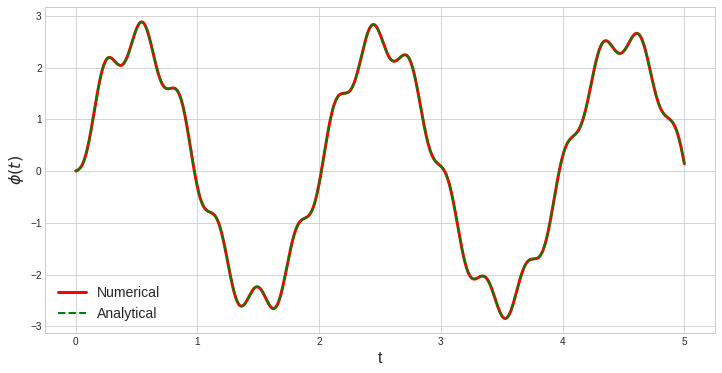

In [14]:
phi0 = [0, 1]
t = np.linspace(0, 5, 1000)
A, m, l, alpha, beta, gamma, omega_dr = [10, 0.1, 0.1, 5, 0, 0.1, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

plt.figure(figsize=(12,6))
plt.plot(t, sol[:, 0], color = 'r', label = "Numerical", linewidth=3)
plt.plot(x,y, linestyle='--', color = 'g', label = "Analytical", linewidth=2)
plt.xlabel('t', fontsize=16)
plt.ylabel(r'$\phi(t)$', fontsize=16);
plt.legend(fontsize=14);

### 2. Setting the Driving and Damping Terms to Zero

Another check is to set the driving and damping terms to zero and again ensure that it behaves as expected. From the plot produced by the code below, we can see that the graph is sinusoidal where the amplitude is constant, which is expected of an undriven and undamped oscillator.

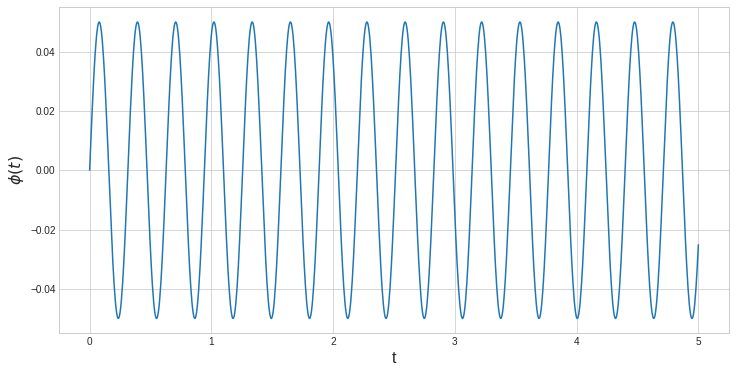

In [15]:
y0 = [0, 1]
t = np.linspace(0, 5, 1000)
A, m, l, alpha, beta, gamma, omega_dr = [0, 0.1, 0.1, 5, 1, 0, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

plt.figure(figsize=(12,6))
plt.plot(t, sol[:, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel(r'$\phi(t)$', fontsize=16);

### 3. Decay of Undriven Damped Oscillation

Since the above two limiting cases are working correctly, we now want to include the non-linear term and check how it affects the system. With the driving term set to zero, we see that the oscillation's amplitude decays due to the damping term, and the pendulum slowly comes to rest after about 150 seconds.

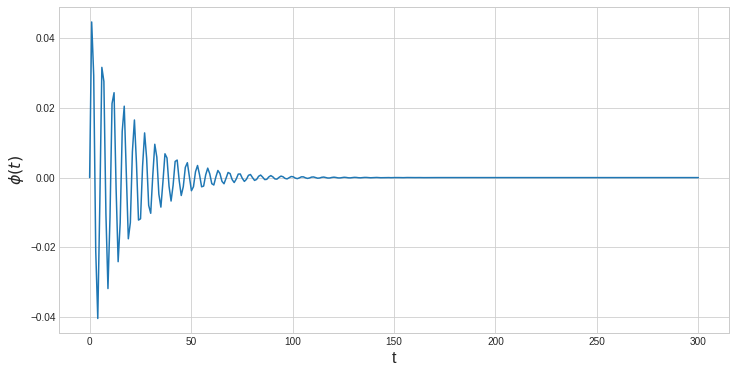

In [16]:
y0 = [0, 1]
t = np.linspace(0, 300, 300)
A, m, l, alpha, beta, gamma, omega_dr = [0, 0.1, 0.1, 5, 1, 0.1, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

plt.figure(figsize=(12,6))
plt.plot(t, sol[:, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel(r'$\phi(t)$', fontsize=16);

## 7. Phase-Space Visualisations
-----

We now proceed to creating phase-space plots of our results by plotting the “position” ($\phi$) and “momentum” ($\dot{\phi}$).

### i. Transient Behaviours

The plots produced by the following code shows the phase-space plots for the transient behaviour where we set the pendulum in motion and let it settle without any driving force and where the pendulum starts at rest with a driving force.


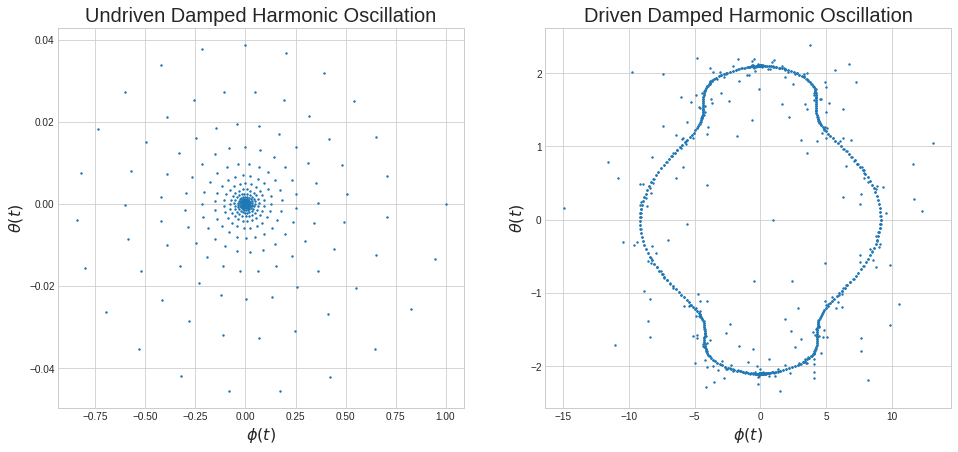

In [29]:
y0 = [1, 0]
t = np.linspace(0, 300, 1000)
A, m, l, alpha, beta, gamma, omega_dr = [0, 0.1, 0.1, 5, 1, 0.1, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax1.scatter(sol[:, 1], sol[:, 0], s=2)
ax1.set_ylabel(r'$\theta(t)$', fontsize=16)
ax1.set_xlabel(r'$\phi(t)$', fontsize=16)
ax1.set_title("Undriven Damped Harmonic Oscillation", fontsize=20)

y0 = [0, 0]
t = np.linspace(0, 300, 1000)
A, m, l, alpha, beta, gamma, omega_dr = [10 , 0.1, 0.1, 5, 1, 0.1, np.pi]
sol = odeint(dy_dt, phi0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))

ax2 = fig.add_subplot(122)
ax2.scatter(sol[:, 1], sol[:, 0], s=2)
ax2.set_ylabel(r'$\theta(t)$', fontsize=16)
ax2.set_xlabel(r'$\phi(t)$', fontsize=16)
ax2.set_title("Driven Damped Harmonic Oscillation", fontsize=20);

## ii. Steady State Behaviour

## 8. Poincaré Sections of Pendulum’s Dynamics
-----
A useful way of analyzing chaotic motion is to look at what is called the Poincaré section. Rather than considering the phase space trajectory for all times, which gives a continuous curve, the Poincaré section is just the discrete set of phase space points of the particle at every period of the driving force, i.e. at $t = \frac{2\pi}{\omega}, \frac{4\pi}{\omega}, \frac{6\pi}{\omega}$, etc. 

Clearly for a periodic orbit the Poincaré section is a single point, when the period has doubled it consists of two points, and so on. The Poincaré plot has been plotted for 20000 periods for a chaotic system. One should note that if the system were not chaotic, most of the points would have been superimposed on each other.

In [31]:
def solve_duffing(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr):
    period = 2*np.pi/omega_dr
    dt = period / nitt
    t_max = ncycle*period
    t = np.arange(0, ncycle*period, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(dy_dt, X0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))
    return t, X, dt

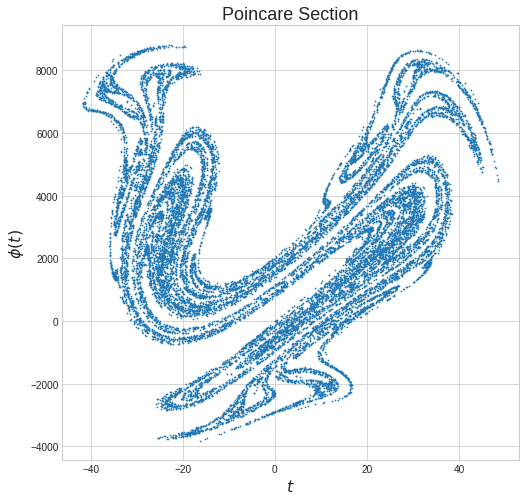

In [40]:
# Set up the motion for a oscillator with initial position
# x0 and initially at rest.
x0, v0 = 0, 0
ncycle = 20000    #number of cycle (number of points in poincare map)
nitt = 100       #number of time step for each cycle
A, m, l, alpha, beta, gamma, omega_dr = [10000, 0.1, 0.1, 0.1, 1, 2, 90]

t, X, dt = solve_duffing(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr)
x, xdot = X.T

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.scatter(x[::nitt], xdot[::nitt], s=3, lw=0)
ax1.set_ylabel(r'$\phi(t)$', fontsize=16)
ax1.set_xlabel(r'$t$', fontsize=16);
ax1.set_title("Poincare Section", fontsize=18);

This strange diagram is the strange attractor. It is the limiting set of points to which the trajectory tends (after the initial transient) every period of the driving force.  Notice the that the attractor is complicated but not completely random, we see structure.  

## 9. Transition to Chaos
-----

We now investigate how the phase space plots change when the strength of the driving force is changed. We set the driving frequency $\omega_{\mathrm{dr}}$ to equal to the natural frequency of the system $\dfrac{\alpha}{ml} - \omega_0^2$ with $m = l = 0.1$ and $\gamma = 2$. The duffing equation is solved for $2000$ periods with $100$ iterations each period. We choose $20000$ periods so that the Poincaré plot obtained is rich in points and the phase plot is accurate.

We have observed (although not shown) that for values of $A$ ranging from $0.1$ to approximately $100$, that the system is almost linear and starts to behave chaotic for values of $A$ above $100$. The Poincaré plot and the last ten cycles of the phase plot for $A=10,000$ has been shown below. We are interested in the last few cycles of the phase plot as we wish to know whether the system is still chaotic or settled into a non-chaotic orbit at the of the simulation.

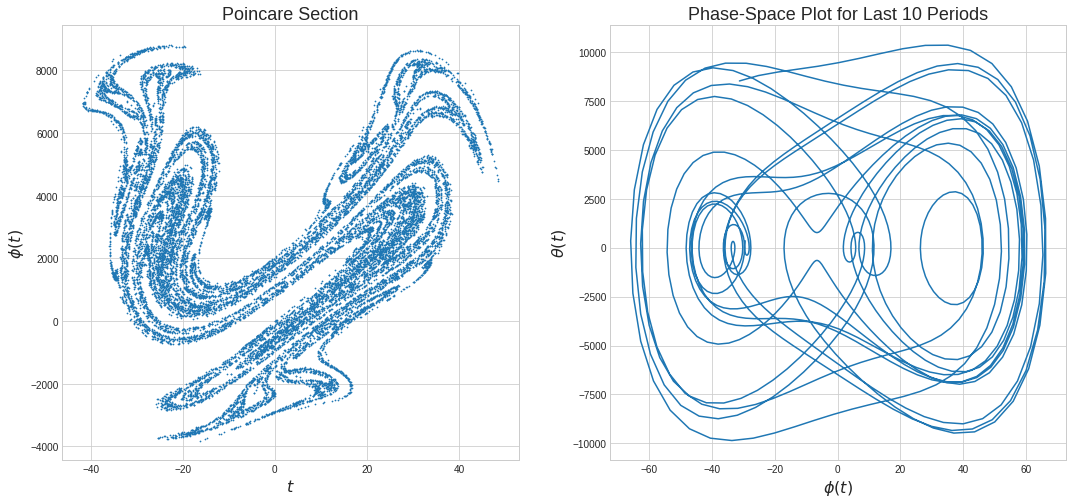

In [41]:
# Set up the motion for a oscillator with initial position
# x0 and initially at rest.
x0, v0 = 0, 0
ncycle = 20000    #number of cycle (number of points in poincare map)
nitt = 100       #number of time step for each cycle
A, m, l, alpha, beta, gamma, omega_dr = [10000, 0.1, 0.1, 0.1, 1, 2, 90]

t, X, dt = solve_duffing(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr)
x, xdot = X.T

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.scatter(x[::nitt], xdot[::nitt], s=3, lw=0)
ax1.set_ylabel(r'$\phi(t)$', fontsize=16)
ax1.set_xlabel(r'$t$', fontsize=16);
ax1.set_title("Poincare Section", fontsize=18)
ax2 = fig.add_subplot(122)
idx = len(x)-1000
ax2.plot(x[idx:], xdot[idx:])
ax2.set_ylabel(r'$\theta(t)$', fontsize=16)
ax2.set_xlabel(r'$\phi(t)$', fontsize=16)
ax2.set_title(r"Phase-Space Plot for Last 10 Periods", fontsize=18);

## 10. Finding the Basins of Attraction
-----

In this section we will analyse the duffing equation for $A = 100$ for different initial values for $\phi_0$ and $\dot{\phi}_0$. Apart from the value of $A$, all the other parameters have the same value. We solve the duffing equations for $200$ periods for faster computation; it doesn't make much difference if we solve for $200$ periods or $2000$ periods as the system is non-chaotic for $A = 100$. We then plot the trajectory of the mass for the first $100$ periods and the phase plot for the first $50$ and the last $100$ periods.


In [42]:
def duffing_ivp(phi0, theta0, ncycle = 200, nitt = 100, duffing_params = [100, 0.1, 0.1, 0.1, 1, 2, 90],
               fig_params = [10000, (16.5,5)]):
    A, m, l, alpha, beta, gamma, omega_dr = duffing_params
    t, X, _ = solve_duffing(ncycle, nitt, phi0, theta0, A, m, l, alpha, beta, gamma, omega_dr)
    x, xdot = X.T
    
    idx, size = fig_params
    fig = plt.figure(figsize = size)
    
    ax1 = fig.add_subplot(131)
    ax1.plot(t[:idx], x[:idx])
    ax1.set_ylabel(r'$\phi(t)$', fontsize=16)
    ax1.set_xlabel(r'$t$', fontsize=16);
    ax1.set_title("Trajectory of Oscillator")
    

    ax2 = fig.add_subplot(132)
    ax2.plot(x[:int(idx/4)], xdot[:int(idx/4)])
    ax2.set_ylabel(r'$\theta(t)$', fontsize=16)
    ax2.set_xlabel(r'$\phi(t)$', fontsize=16)
    ax2.set_title(r"Phase-Space Plot for Periods 0 to 50")
    ax2.dist=8

    ax3 = fig.add_subplot(133)
    ax3.plot(x[len(x)-idx:], xdot[len(x)-idx:])
    ax3.set_ylabel(r'$\theta(t)$', fontsize=16)
    ax3.set_xlabel(r'$\phi(t)$', fontsize=16)
    ax3.set_title(r"Phase-Space Plot for Periods 100 to 200")

    return x[len(x)-idx:]


# 3D Scatter Plot of Time in X Axis and Theta and Phi in the Y and Z axis
def duffing_ivp_3D(phi0, theta0, ncycle = 200, nitt = 100, duffing_params = [100, 0.1, 0.1, 0.1, 1, 2, 90]):
    A, m, l, alpha, beta, gamma, omega_dr = duffing_params
    t, X, _ = solve_duffing(ncycle, nitt, phi0, theta0, A, m, l, alpha, beta, gamma, omega_dr)
    x, xdot = X.T
    fig=plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(2,None)
    ax.scatter(t,x,xdot, c=t, cmap='viridis')
    ax.set_xlabel(r'$t$',fontsize=16)
    ax.set_ylabel(r'$\phi$',fontsize=16)
    ax.set_zlabel(r'$\theta$',fontsize=16)
    # Set spacing b/w the labels and the plot.
    ax.xaxis.labelpad=15
    ax.yaxis.labelpad=15
    ax.zaxis.labelpad=15;

### a.  Oscillator Starting at Rest in the Positive Potential Well


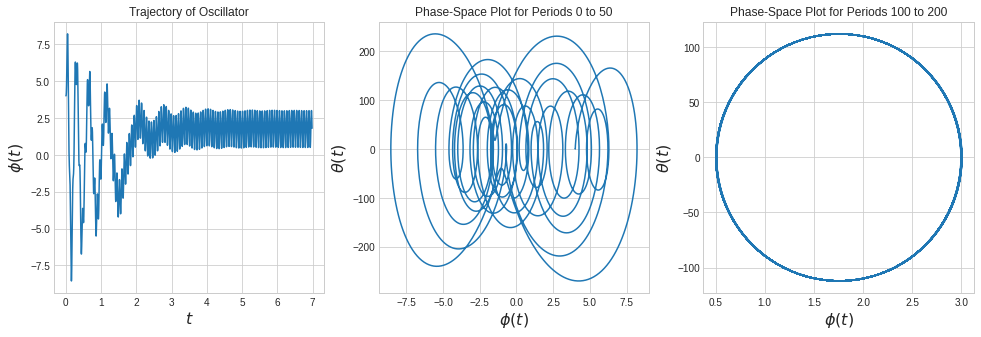

In [43]:
# Set up the motion for a oscillator with initial position
# theta and initially at rest.
phi0, theta0 = 4, 0
duffing_ivp(phi0, theta0);

### b.  Oscillator Starting at Rest in the Negative Potential Well


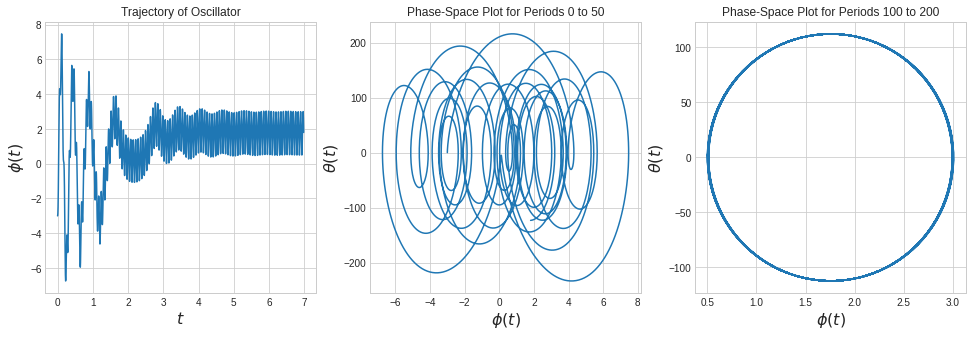

In [44]:
phi0, theta0 = -3, 0
duffing_ivp(phi0, theta0);

### c.  Oscillator Starting with Velocity between Wells


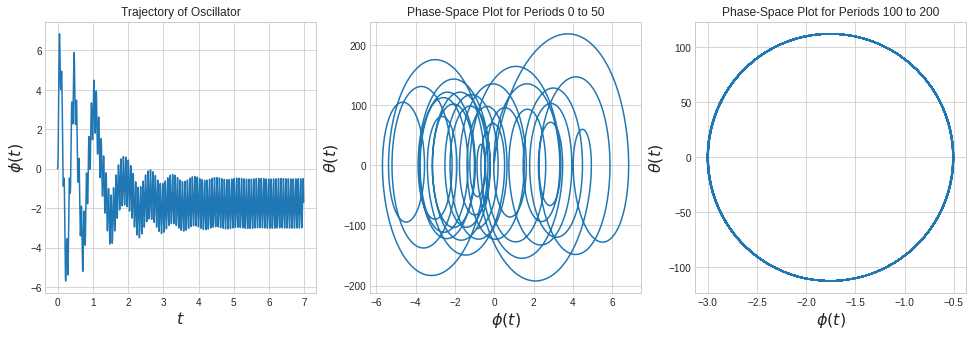

In [45]:
phi0, theta0 = 0, 5
duffing_ivp(phi0, theta0);

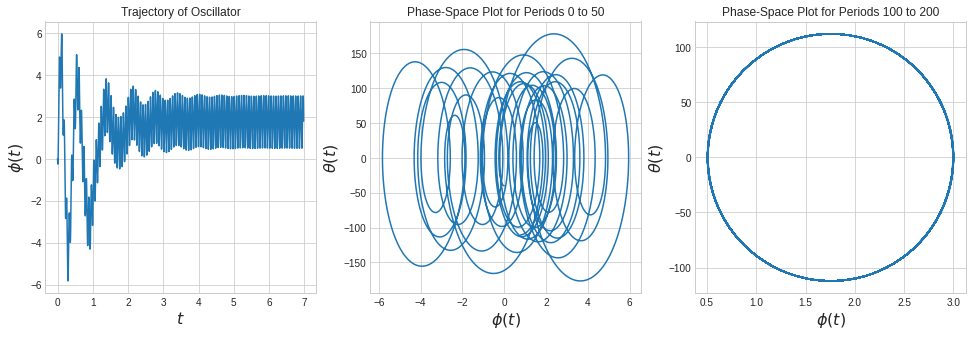

In [46]:
phi0, theta0 = 0, -40
duffing_ivp(phi0, theta0);

For the values of driving force amplitude ranging from $0.1$ to $108$, we can see from the above plots that the oscillator  takes a while to “decide” which stable point to oscillate around. This is the regime between linear behaviour and
chaotic behaviour. We used it to map out the basins of attraction over a range of initial value in phase
space (initial position and momentum) and can observe that the pattern depends on the choice of parameters.


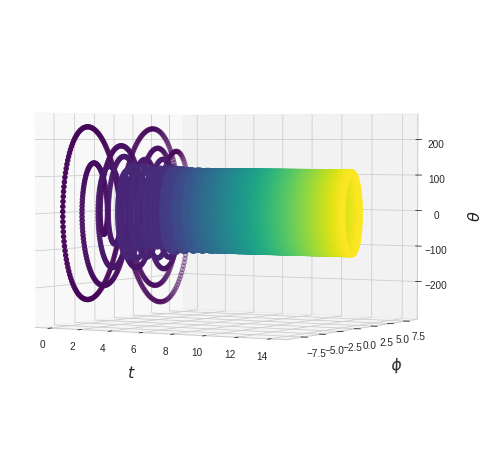

In [25]:
phi0, theta0 = 4, 0
duffing_ivp_3D(phi0, theta0);

The above diagram is a 3D plot of the first case where the oscillator starts at rest in the positive potential. The transition from the chaotic to linear regime is visible where the trajectory of the motion is chaotic in the beginning and slow settles into a stable orbit around the positive potential as time progresses.

## 11. Assessing Which Side of the Oscillator is On
-----


In this section, we wish to write a function that would simulate the dynamics of the chaotic pendulum and produce an output indicating which side of the double well potential the oscillator is on along with the relevant plots. We simply make use of the `duffing_ivp` and check its output (which is the last 100 periods of the $\phi$ value). If all its values are positive (or negative) then the oscillator has settled into the positive (or negative) potential of the double. If the values contain a mixture of positive and negative values, then it implies that the oscillators motion is still chaotic and is hopping between both potentials.

In [47]:
def oscillator_on(phi0, theta0):
    ncycle = 200  #number of cycle (number of points in poincare map)
    nitt = 100      #number of time step for each cycle
    duffing_params = [100, 0.1, 0.1, 0.1, 1, 2, 90]

    fig_params = [10000, (16.5,5)]

    
    x = duffing_ivp(phi0, theta0, ncycle, nitt, duffing_params, fig_params)
    
    if all(i > 0 for i in x):
        print("The oscillator is on its right side.")
    elif all(i < 0 for i in x):
        print("The oscillator is on its left side.")
    else:
        print("The oscillator is on on both sides.")

The oscillator is on its right side.


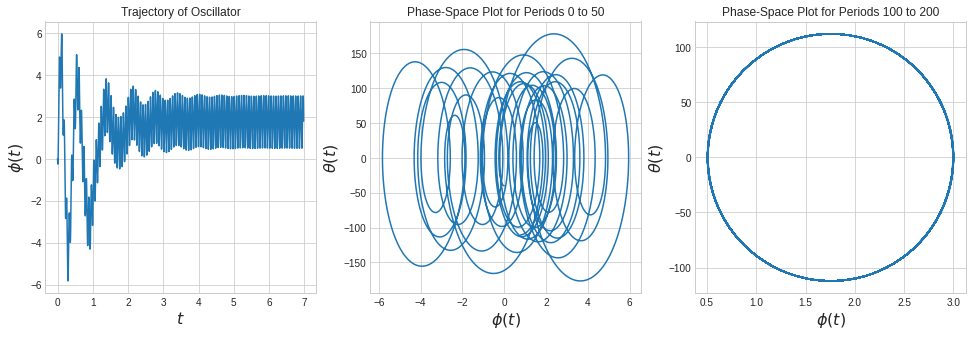

In [48]:
phi0, theta0 = 0, -40
oscillator_on(phi0, theta0)

## 12. Bifurcation Diagram
-----

In this section we begin the analysis of the bifurcation diagram for the chaotic oscillator defined by the duffing equation. The first plot shown below is the plot of $A$ values on the $x$ axis and the $\phi$ values on the $y$ axis. The plot was produced for $A$ values ranging from $0.0$ to $10000$ and values of $\phi$ for each $A$ obtained at the end of $20$ periods.

In [23]:
dlist = []
xlist = []
for i in range(0,10000,1):
    x0, v0 = 0, 0
    ncycle = 20    #number of cycle (number of points in poincare map)
    nitt = 100       #number of time step for each cycle
    A, m, l, alpha, beta, gamma, omega_dr = [i, 0.1, 0.1, 0.5, 1, 2, 90]

    t, X, dt = solve_duffing(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr)
    x, xdot = X.T
    dlist.append(i)
    xlist.append(x[len(x)-1])

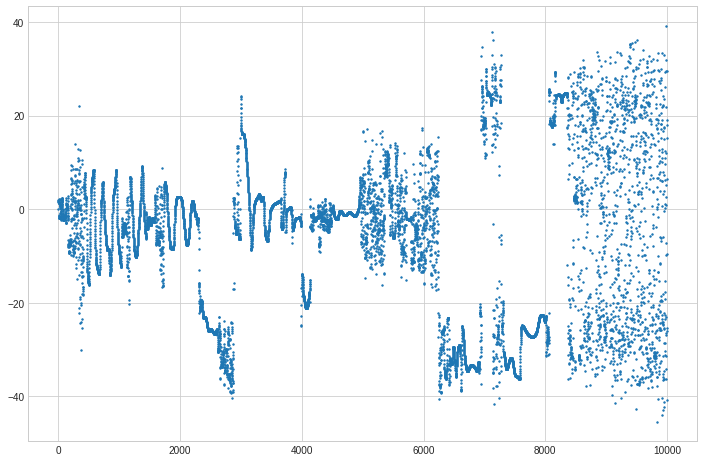

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(dlist, xlist, s=2);

From the above plot we can regions that are highly chaotic and those that seem to be less chaotic. However, the above plot is not of much use for the purpose of bifurcation analysis. To make our analysis simpler and computation faster, we proceed to manipulate the duffing equation into a more familiar form that has been studied by many mathematicians and physicists.

Previously, we had the duffing equation of the form

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} + \bigg(\dfrac{\alpha}{ml} - \omega_0^2 \bigg) \phi + \omega_0^2 \dfrac{\phi^3}{6}  &= \dfrac{1}{ml} A \sin (\omega_{\mathrm{dr}} t)
\end{align*}

To make the analysis of bifurcation much simpler we make the following substitutions, $m = \frac{6}{10}$, $l = \frac{10}{6}$, $\alpha = 5$, and $g \approx 10$. We also express $\sin(\omega_{\mathrm{dr}} t)$ as $\cos \bigg(\dfrac{\pi}{2}-\omega_{\mathrm{dr}} t \bigg)$. The duffing equation then becomes

\begin{align*}
\ddot{\phi} + \gamma \dot{\phi} - \phi + \phi^3  &= A \cos \bigg(\dfrac{\pi}{2}-\omega_{\mathrm{dr}} t \bigg)
\end{align*}

We study the bifurcation produced by the above duffing equation for $5000$ values of $A$ ranging from $0.3$ to $0.35$ with $\gamma = 0.1$ and $\omega_{\mathrm{dr}} = 1.4$. It starts with $\phi = 0$ and $\dot{\phi} = 0$, i.e at rest in $\phi = 0$ minimum. The equations are integrated for 2000 periods of the driving force and the value of x plotted at the end of each of the remaining 2000 periods.


In [97]:
@jit(nopython=True)
def dy_dt_cos(phi0,t, A, m, l, alpha, beta, gamma, omega_dr):
    g = 10
    omega_0 = np.sqrt(g/l)
    phi, theta = phi0 # phi0 is the vector [phi, theta]; contains the initial conditions of the system
    dtheta = A*np.cos(90-omega_dr*t)/(m*l) - gamma*theta - phi*(alpha/(m*l)-omega_0**2) - beta*(omega_0**2)*((phi**3)/6)
    dydt = [theta, dtheta]
    return dydt

def solve_duffing_cos(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr):
    period = 2*np.pi/omega_dr
    dt = period / nitt
    t_max = ncycle*period
    t = np.arange(0, ncycle*period, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(dy_dt_cos, X0, t, args=(A, m, l, alpha, beta, gamma, omega_dr))
    return t, X, dt

In [98]:
dlist = np.linspace(0.3,0.35,5000)
xlist = []
for i in dlist:
    x0, v0 = 0, 0
    ncycle = 2000    #number of cycle (number of points in poincare map)
    nitt = 100       #number of time step for each cycle
    A, m, l, alpha, beta, gamma, omega_dr = [i, 6/10, 10/6, 5, 1, 0.1, 1.4]
    t, X, dt = solve_duffing_cos(ncycle, nitt, x0, v0, A, m, l, alpha, beta, gamma, omega_dr)
    x, xdot = X.T
    xlist.append(x[len(x)-1])

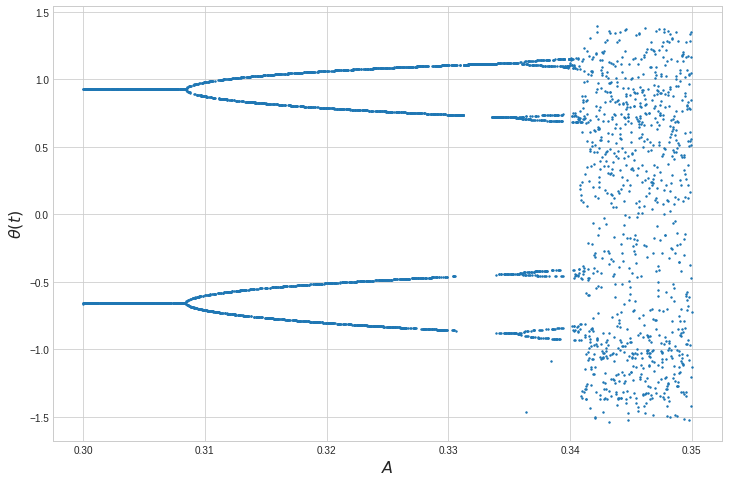

In [102]:
plt.figure(figsize=(12,8))
plt.scatter(dlist[:len(xlist)], xlist, s=2)
plt.ylabel(r'$\theta(t)$', fontsize=16)
plt.xlabel(r'$A$', fontsize=16);

One clearly sees period doubling leading into chaos. I should mention that, for Poincaré sections in this region of d, the system is hopping between the vicinity of the well at positive x and in the vicinity of the the well at negative x. Contrary to the above plot, one must note when plotting the figure, it is convenient that the system is always in the vicinity of the same well

The Feigenbaum constant is the ratio of the range over which a limit cycle has a certain period, to the range where the period is doubled. Being universal, it is expected to have the same value, 4.6692..., in this period doubling route to chaos (which comes from a differential equation), as it has in the logistic map (which  involves iterating a map). This is a remarkable result, which is expected to be true, but I have not seen it demonstrated explicitly.

From the above plot, we can estimate the three period doublings to occur at 

\begin{align*}
A_2 &= 0.3084 \\
A_3 &= 0.3358 \\
A_4 &= 0.3396
\end{align*}

We can calculate the Feigenbaum value by using the relation

\begin{align*}
\delta_n = \dfrac{A_n - A_{n-1}}{A_{n+1}-A_n}
\end{align*}

with which we obtain $\delta_2 = 7.21053$. It is possible that these values tend to the Feigenbaum value 4.6692 ... for large k, but it seems to be quite challenging numerically to demonstrate this convincingly since it would require going to several more levels of period doubling.  

If you are wondering how I managed to determine the values for $A_n$ to 4-digit precision from the graph, `matplotlib` can be configured to display plots in interactive mode which displays the coordinates of the location of the curson on the graph.